# Learning the fractals with neural networks

One version of the universal approximation theorem is that a feedforward neural network can approximate any uniformly continuous functions up to any arbitrarily small error. The famous Mandelbrot set $\mathcal{M}$, a fractal from complex dynamics, is a binary classifier of points in the complex plane $\mathbb{C}$. Although binary classifiers are non-continuous, in this short notebook we will see if neural network can recognize any self-similar structure.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Preliminaries, complex dynamics


The binary classifier which produces $\mathcal{M}$ is as follows: 

Let $p_c: \mathbb{C} \rightarrow \mathbb{C}$, $p_{c}(z)=z^2 + c$ be a polynomial that depends on the complex parameter $c$. For each $c$, we let $z=0$ be the initial condition, and iterate it by the polynomial $p_c$, i.e. 

$0 \rightarrow p_c(0)\rightarrow p_c(p_c (0)) \rightarrow p_c(p_c(p_c (0))) \rightarrow ...$ 

This is called the orbit of $0$ under $p_c$. 

If the orbit goes off to $\infty$, we classify it as $0$. Otherwise, if the orbit stays bounded, we classiify it as $1$. It can be proved that an escape radius of $4$ is generally enough, but we have to decide on the number of iterates to get there.

In [2]:
def polynomial_iteration(c, no_of_iterate, escape_radius):
    z_i = complex(*c)
    c   = complex(*c)
    for _ in range(no_of_iterate):
        z_i = (z_i ** 2) + c
        if abs(z_i) > escape_radius:
            return 0
    return 1

# Creating the training set

We now create the training set. 

It is known that $\mathcal{M}$ is a subset in the complex plane within $[-2,1] \times [-1,1]$, so we first obtain a set of discrete coordinates $(x,y)$ using numpy.

X_train consists of the arrays that represent the x, y coordinates (2 features). y_train consists of 0-1 labels according to whether the orbit of $0$ goes off to $\infty$ under iteration of $p_c$. 

The validation set and test set are defined similarly. They are produced by slightly shifting the X_train coordinates.

**Remark:**it is possible we mislaballed, because we used finite iterates and finite escape radius in our determination of the labels. It maybe valuable to be able to provide an upper bound on the mislabels according to, say, the number of iterates, and relate this to agnostic PAC learnability.

In [3]:
# determine the number of points in each axis.
x_grid = 400*3
y_grid = 400*2

# create the x, y coordinates, x in [-2,1], y in [-1,1].
x_coord_train = np.linspace(-2, 1, x_grid)
y_coord_train = np.linspace(-1, 1, y_grid)

# create X_train, the Cartesian products of the coordinates created above.
# create y_train, the labels using polynomial_iteration.
X_train = np.transpose([np.tile(x_coord_train, len(y_coord_train)), np.repeat(y_coord_train, len(x_coord_train))])
y_train = np.array([polynomial_iteration(point, 50, 4) for point in X_train])


# similarly create the validation set X_validation, y_validation.
x_coord_validation = np.linspace(-2, 1, x_grid) + ((2*3)/(x_grid*3))
y_coord_validation = np.linspace(-1, 1, y_grid) + ((2*2)/(y_grid*3))

X_validation = np.transpose([np.tile(x_coord_validation, len(y_coord_validation)), np.repeat(y_coord_validation, len(x_coord_validation))])
y_validation = np.array([polynomial_iteration(point, 50, 4) for point in X_validation])


# similarly create the test set X_test, y_test.
x_coord_test = np.linspace(-2, 1, x_grid) + (3/(x_grid*3))
y_coord_test = np.linspace(-1, 1, y_grid) + (2/(y_grid*3))

X_test = np.transpose([np.tile(x_coord_test, len(y_coord_test)), np.repeat(y_coord_test, len(x_coord_test))])
y_test = np.array([polynomial_iteration(point, 50, 4) for point in X_test])





In [4]:
X_train.shape

(960000, 2)

In [5]:
y_train.shape

(960000,)

A simple function for quick visualizations.

In [6]:
def create_figure(label_array, figsize_length, figsize_height):
    plt.figure(figsize=(figsize_length, figsize_height))
    plt.imshow(label_array, cmap='gray')
    

Making sure we're doing the right thing, we can visualize the three datasets, which should look the same (just the Mandelbrot set).

In [7]:
# y_train, y_validation, and y_test are 1d numpy array,
# in order to plot them on the plane, we need to resize y_train according to x_grid, y_grid

plot_train = y_train.reshape(y_grid, x_grid)
plot_validation = y_validation.reshape(y_grid, x_grid)
plot_test = y_test.reshape(y_grid, x_grid)

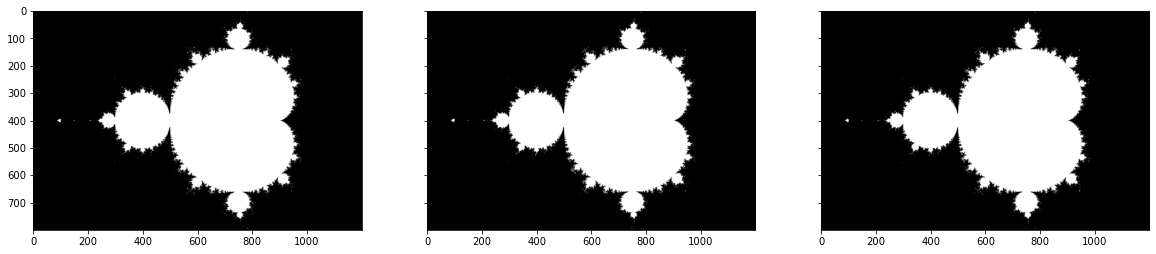

In [8]:
f, axarr = plt.subplots(1,3, 
                        figsize=(20,12),
                        sharex=True, sharey=True)

axarr[0].imshow(plot_train, cmap='gray')
axarr[1].imshow(plot_validation, cmap='gray')
axarr[2].imshow(plot_test, cmap='gray')
       

Training set with a bit more detail.

We can see that the training set isn't great itself. One reason is that $\mathcal{M}$ is supposed to be connected, but in this plot it looks quite disconnected - e.g. center left: the few white islands should be connected by a very thin line.  Our classifier did not pick up those points as being in the Mandelbrot sets. 

These issues could be mitigated by increasing the training set size (using finer grids), or setting a larger escape_radius, or increase the no_of_iterate. The downside is increase in training time (coming up next).

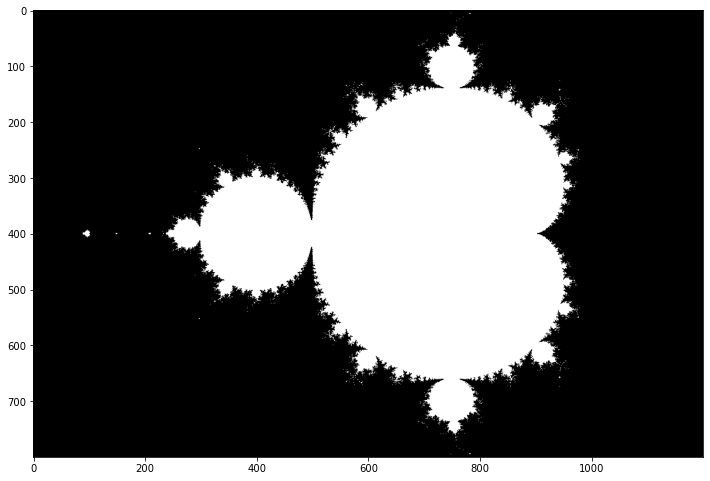

In [9]:
plt.figure(figsize=(12, 10))
plt.imshow(plot_train, cmap='gray')

# Building our neural network

We will use tensorflow/keras to build our neural networks. Our goal is to find a network architecture and activation function that can understand the fractal structure to some extent. Once the number of hidden layers is specified, the number of neurons in each hidden layer will be half of that in the previous one (last hidden layer has 2 neurons). Other variables for building the model are
<br>- number of hidden layers
<br>- activation functions for hidden layers
<br>- activation functions for output layer
<br>- number of epochs
<br>- batch sizes

The activation functions we will try are
<br>- Hyperbolic tangent (tanh)
<br>- Exponential linear unit (ELU)
<br>- Sigmoid

We chose ELU over ReLU to avoid [dead neurons](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks).

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical


In [11]:
def create_mandelbrot_model(no_of_hidden_layers,
                            hidden_activation,
                            epochs, 
                            batch_size):

    model = Sequential()
    model.add(Dense(units=2,activation=hidden_activation))
    
    for i in range(no_of_hidden_layers):
        model.add(Dense(units=(no_of_hidden_layers-i)*2,activation=hidden_activation))
        
    model.add(Dense(units=1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(x=X_train, 
          y=y_train, 
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(X_validation, y_validation),
          verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)]
          )
    
    return model

## Model 1 of 3 (tanh)

To begin, we will roughly follow the 2/3 rule: the number of hidden neurons should be 2/3 the size of the input layer. The training set consists of 960,000 points which is roughly to the order $2^{19}$, so we will try 19 layers.

For other variables we try:
<br>Rectified Linear Unit (hidden layers)
<br>40 epochs
<br>1000 batch size

In [12]:
first_mandelbrot = create_mandelbrot_model(18, 'tanh', 40, 256)

Epoch 1/40
3750/3750 [==============================] - 11s 3ms/step - loss: 0.2175 - val_loss: 0.0815
Epoch 2/40
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0787 - val_loss: 0.0761
Epoch 3/40
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0667 - val_loss: 0.0598
Epoch 4/40
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0622 - val_loss: 0.0563
Epoch 5/40
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0569 - val_loss: 0.0531
Epoch 6/40
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0548 - val_loss: 0.0500
Epoch 7/40
3750/3750 [==============================] - 8s 2ms/step - loss: 0.0536 - val_loss: 0.0454
Epoch 8/40
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0502 - val_loss: 0.0442
Epoch 9/40
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0486 - val_loss: 0.0448
Epoch 10/40
3750/3750 [==============================] - 15s 4ms/step - loss: 0

**Losses:** The training and validation losses are still decreasing steadily without diverging, so we are unlikely to be overfitting. However, the network is improving slowly after 8 epochs or so.

<AxesSubplot:>

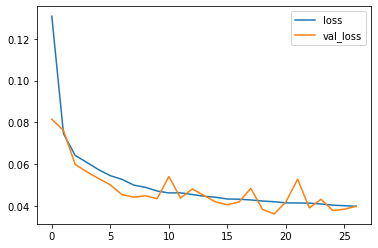

In [13]:
model_loss = pd.DataFrame(first_mandelbrot.history.history)
model_loss.plot()

**First model performance:** We can visualize how the first model performs on the test set.

C:\Users\ivanc\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


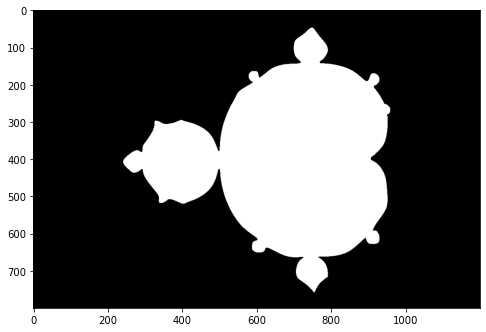

In [14]:
first_model_prediction = first_mandelbrot.predict_classes(X_test)
first_model_prediction = first_model_prediction.reshape(y_grid , x_grid)

create_figure(first_model_prediction, 8, 6)

Not too bad, it seems the network is able to at least capture a rough outline of the Mandelbrot set.



## Model 2 of 3 (ELU)
We will keep the network architecture (for now) beside changing the activation function to ELU.

In [15]:
second_mandelbrot = create_mandelbrot_model(18, 'elu', 40, 256)

Epoch 1/40
3750/3750 [==============================] - 13s 3ms/step - loss: 0.1939 - val_loss: 0.0617TA: 5s - loss: 0.3 - ETA: 5s - loss: 0.  - ETA: 0s - loss: 0. - ETA: 0s - loss: 
Epoch 2/40
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0695 - val_loss: 0.0635
Epoch 3/40
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0614 - val_loss: 0.0782
Epoch 4/40
3750/3750 [==============================] - 13s 4ms/step - loss: 0.0581 - val_loss: 0.0793
Epoch 5/40
3750/3750 [==============================] - 13s 4ms/step - loss: 0.0563 - val_loss: 0.0562
Epoch 6/40
3750/3750 [==============================] - 13s 4ms/step - loss: 0.0535 - val_loss: 0.0612
Epoch 7/40
3750/3750 [==============================] - 15s 4ms/step - loss: 0.0527 - val_loss: 0.0504
Epoch 8/40
3750/3750 [==============================] - 14s 4ms/step - loss: 0.0510 - val_loss: 0.0514
Epoch 9/40
3750/3750 [==============================] - 13s 3ms/step - loss: 0.0497 - val_loss: 

**Losses:** about the same as before

<AxesSubplot:>

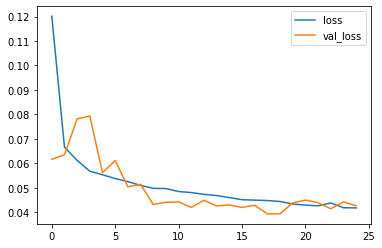

In [16]:
model_loss = pd.DataFrame(second_mandelbrot.history.history)
model_loss.plot()

**Second model performance:** ELU seems to produce a slightly better plot, but tanh trained faster. 

C:\Users\ivanc\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


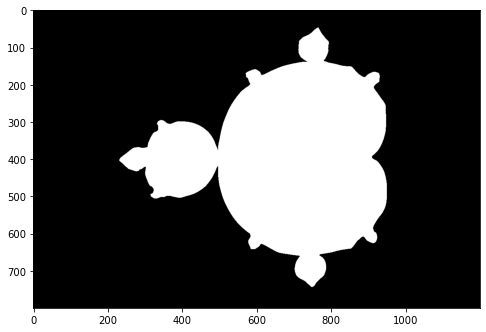

In [17]:
second_model_prediction = second_mandelbrot.predict_classes(X_test)
second_model_prediction = second_model_prediction.reshape(y_grid , x_grid)

create_figure(second_model_prediction, 8, 6)

## Model 3 of 3 (Sigmoid)

In [18]:
third_mandelbrot = create_mandelbrot_model(18, 'sigmoid', 40, 256)

Epoch 1/40
3750/3750 [==============================] - 8s 2ms/step - loss: 0.5789 - val_loss: 0.5774
Epoch 2/40
3750/3750 [==============================] - 7s 2ms/step - loss: 0.5773 - val_loss: 0.5774
Epoch 3/40
3750/3750 [==============================] - 7s 2ms/step - loss: 0.5777 - val_loss: 0.5773
Epoch 4/40
3750/3750 [==============================] - 7s 2ms/step - loss: 0.5773 - val_loss: 0.5773
Epoch 5/40
3750/3750 [==============================] - 7s 2ms/step - loss: 0.5780 - val_loss: 0.5774
Epoch 6/40
3750/3750 [==============================] - 8s 2ms/step - loss: 0.5775 - val_loss: 0.5774
Epoch 7/40
3750/3750 [==============================] - 8s 2ms/step - loss: 0.5775 - val_loss: 0.5773
Epoch 8/40
3750/3750 [==============================] - 8s 2ms/step - loss: 0.5778 - val_loss: 0.5774
Epoch 9/40
3750/3750 [==============================] - 7s 2ms/step - loss: 0.5780 - val_loss: 0.5773
Epoch 10/40
3750/3750 [==============================] - 8s 2ms/step - loss: 0.577

**Losses:** 

<AxesSubplot:>

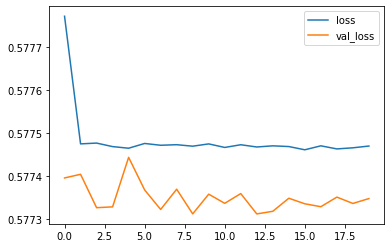

In [19]:
model_loss = pd.DataFrame(third_mandelbrot.history.history)
model_loss.plot()

**Third model performance:** the network died in the beginning and got early stopped out. This is similar to the [dead neurons](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks) problem when using ReLu activation. 

C:\Users\ivanc\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


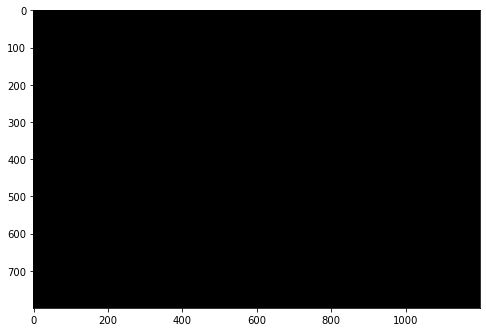

In [20]:
third_model_prediction = third_mandelbrot.predict_classes(X_test)
third_model_prediction = third_model_prediction.reshape(y_grid , x_grid)

create_figure(third_model_prediction, 8, 6)

tanh and ELU were both able to give a rough outline of the Mandelbrot set, but sigmoid got stopped out too early. Given that the training data isn't great to begin with, I think these networks work out quite decently. It'd be interesting to try other fractals instead of the Mandelbrot set. One way is to replace the iterated function by something else, e.g. the one below. 

It is known that the fractal produced is among the region $−2 \leq Re  \leq 4,  −3 \leq Im \leq 3$. 

In [21]:
def rational_iteration(q, no_of_iterate, escape_radius, trap_radius):
    y_i = complex(0,0)
    q   = complex(*q)
    for _ in range(no_of_iterate):
        y_i = (( y_i ** 2 + q - 1) / ( 2*y_i + q - 2)) ** 2
        if abs(y_i) > escape_radius:
            return 0
        elif abs(y_i - 1) < trap_radius:
            return 1
    return 2

In [22]:
# determine the number of points in each axis.
x_grid = 400*3
y_grid = 400*3

# create the x, y coordinates, x in [-2,1], y in [-1,1].
x_coord_train = np.linspace(-2, 4, x_grid)
y_coord_train = np.linspace(-3, 3, y_grid)

# create X_train, the Cartesian products of the coordinates created above.
# create y_train, the labels using polynomial_iteration.
X_train = np.transpose([np.tile(x_coord_train, len(y_coord_train)), np.repeat(y_coord_train, len(x_coord_train))])
y_train = np.array([rational_iteration(point, 50, 10, 0.1) for point in X_train])





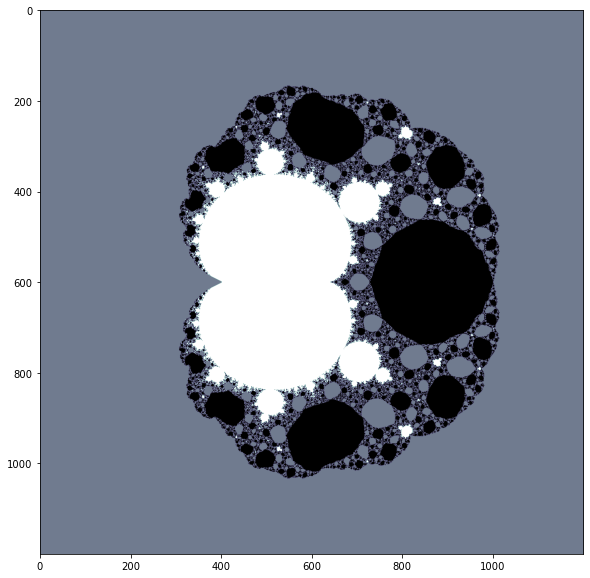

In [23]:
plot_train = y_train.reshape(y_grid, x_grid)
plt.figure(figsize=(12, 10))
plt.imshow(plot_train, cmap='bone')